In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import linear_reset
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.diagnostic import normal_ad

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 160)

In [2]:
TEXT_PATH  = "text_features_qa_only.csv"
EVENT_PATH = "event_AR_CAR_mm_ff3.csv"

text = pd.read_csv(TEXT_PATH, parse_dates=["file_date"])
ev   = pd.read_csv(EVENT_PATH, parse_dates=["AnnounceDate", "datadate"])

print("text shape:", text.shape)
print("ev shape:  ", ev.shape)

text.head(3)

text shape: (2549, 30)
ev shape:   (9966, 12)


,file_name,file_date,ric_from_fname,n_words,n_chars,num_count,pct_count,money_count,sent_vader,kw_synergy,kw_accretive,kw_dilutive,kw_debt,kw_integration,kw_guidance,kw_growth,kw_risk,kw_concern,kw_uncertain,kw_delay,kw_margin,kw_cost,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7
0,2003-Dec-08-Acxiom LLC-140477246411-Brief.txt,2003-12-08,NaN,5136,29354,137,0,2,1.0000,1,1,1,1,1,0,1,0,0,0,0,1,1,0.0,0.0,0.060209,0.005751,0.003290,0.000079,0.006208,0.000000
1,2003-Dec-15-MFE.N^C11-138286857648-Brief.txt,2003-12-15,MFE.N^C11,1888,10775,71,0,0,0.9998,0,0,0,0,0,1,0,0,1,0,0,1,0,0.0,0.0,0.043835,0.000000,0.000000,0.003539,0.000000,0.011314
2,2003-Dec-16-NFB.N^L06-136907498398-Brief.txt,2003-12-16,NFB.N^L06,6565,37640,251,0,18,1.0000,0,0,0,1,0,0,1,0,0,0,0,1,1,0.0,0.0,0.040930,0.001415,0.006005,0.012583,0.000000,0.004564


In [3]:
print("Text columns:\n", text.columns.tolist())
print("\nEvent columns:\n", ev.columns.tolist())

print("\nText date range:", text["file_date"].min(), "→", text["file_date"].max())
print("Event announce date range:", ev["AnnounceDate"].min(), "→", ev["AnnounceDate"].max())
print("Unique RICs in text (non-null):", text["ric_from_fname"].dropna().nunique())
print("Unique RICs in events:", ev["RIC"].nunique())

Text columns:
 ['file_name', 'file_date', 'ric_from_fname', 'n_words', 'n_chars', 'num_count', 'pct_count', 'money_count', 'sent_vader', 'kw_synergy', 'kw_accretive', 'kw_dilutive', 'kw_debt', 'kw_integration', 'kw_guidance', 'kw_growth', 'kw_risk', 'kw_concern', 'kw_uncertain', 'kw_delay', 'kw_margin', 'kw_cost', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7']

Event columns:
 ['RIC', 'AcquirorName', 'TargetName', 'AnnounceDate', 'datadate', 'tau', 'prccd', 'ret', 'ar_mm', 'car_mm', 'ar_ff3', 'car_ff3']

Text date range: 2003-12-08 00:00:00 → 2022-12-19 00:00:00
Event announce date range: 1995-02-13 00:00:00 → 2021-12-23 00:00:00
Unique RICs in text (non-null): 1239
Unique RICs in events: 906


In [ ]:
event_key = ["RIC", "AnnounceDate"]

window = ev[ev["tau"].isin([-1, 0, 1])].copy()

event_car = (
    window.groupby(event_key, as_index=False)
          .agg(
              CAR_mm_m1_p1=("ar_mm", "sum"),
              CAR_ff3_m1_p1=("ar_ff3", "sum"),
              prccd_mean_win=("prccd", "mean")
          )
)

event_car.head()

,RIC,AnnounceDate,CAR_mm_m1_p1,CAR_ff3_m1_p1,prccd_mean_win
0,A.N,2003-06-05,-0.013623,-0.029006,19.623333
1,AABA.OQ^J19,2002-11-15,0.104848,0.106737,17.303333
2,AAP.N,2005-08-10,-0.057880,-0.055828,68.016667
3,ABBV.N,2013-05-14,0.010244,0.012470,45.306667
4,ABT.N,2003-04-04,-0.001495,0.011295,39.910000


In [ ]:
text2 = text.copy()

# standardize and keep only matchable rows
text2["RIC"] = text2["ric_from_fname"].astype(str).replace({"nan": np.nan})
text2 = text2.dropna(subset=["RIC", "file_date"]).copy()

print("Rows in text2 (matchable):", text2.shape[0])
text2[["file_name", "file_date", "RIC"]].head()

Rows in text2 (matchable): 2418


,file_name,file_date,RIC
1,2003-Dec-15-MFE.N^C11-138286857648-Brief.txt,2003-12-15,MFE.N^C11
2,2003-Dec-16-NFB.N^L06-136907498398-Brief.txt,2003-12-16,NFB.N^L06
3,2003-Dec-18-CL.N-139888600104-Brief.txt,2003-12-18,CL.N
4,2003-Dec-19-MDCO.OQ^A20-139635792615-Brief.txt,2003-12-19,MDCO.OQ^A20
5,2003-Dec-19-SSP.OQ-140915381200-Brief.txt,2003-12-19,SSP.OQ


In [8]:
df = pd.merge(
    text2,
    event_car,
    on=["RIC"],
    how="inner"
)

print("Exact merge rows:", df.shape[0])
df[["file_name", "file_date", "RIC", "CAR_ff3_m1_p1"]].head()
df["year"] = df["file_date"].dt.year
df[["file_name","file_date","RIC","AnnounceDate","CAR_ff3_m1_p1"]].head()

Exact merge rows: 1831


,file_name,file_date,RIC,AnnounceDate,CAR_ff3_m1_p1
0,2003-Dec-15-MFE.N^C11-138286857648-Brief.txt,2003-12-15,MFE.N^C11,2003-01-06,0.104782
1,2003-Dec-16-NFB.N^L06-136907498398-Brief.txt,2003-12-16,NFB.N^L06,2003-01-29,0.005690
2,2003-Dec-18-CL.N-139888600104-Brief.txt,2003-12-18,CL.N,2004-12-13,0.001350
3,2003-Dec-19-MDCO.OQ^A20-139635792615-Brief.txt,2003-12-19,MDCO.OQ^A20,2008-08-05,0.039280
4,2003-Dec-19-SSP.OQ-140915381200-Brief.txt,2003-12-19,SSP.OQ,2003-12-19,-0.012806


In [9]:
df["log_words"] = np.log1p(df["n_words"])
df["log_nums"]  = np.log1p(df["num_count"])
df["log_money"] = np.log1p(df["money_count"])

topic_vars = [c for c in df.columns if c.startswith("topic_")]

df[["CAR_ff3_m1_p1", "sent_vader", "log_words", "log_nums", "log_money", "pct_count"]].describe()

,CAR_ff3_m1_p1,sent_vader,log_words,log_nums,log_money,pct_count
count,1831.000000,1788.000000,1831.000000,1831.000000,1831.000000,1831.000000
mean,0.002304,0.999772,8.204058,5.471390,1.965544,8.318951
std,0.089748,0.002771,1.367152,1.398320,0.973920,8.457471
min,-0.713001,0.902300,0.000000,0.000000,0.000000,0.000000
25%,-0.021175,0.999900,8.119994,4.639560,1.386294,2.000000
50%,0.001649,1.000000,8.459564,5.298317,2.079442,6.000000
75%,0.026475,1.000000,8.733191,6.687732,2.708050,12.000000
max,0.883096,1.000000,9.780133,7.839919,4.060443,58.000000


In [ ]:
X = df[text_vars + controls].copy()

# year FE only if df has 'year'
if "year" in df.columns:
    year_dummies = pd.get_dummies(df["year"], prefix="yr", drop_first=True)
    X = X.join(year_dummies)

# add constant
X = sm.add_constant(X, has_constant="add")

# convert everything to numeric, force failures to NaN
X = X.apply(lambda s: pd.to_numeric(s, errors="coerce"))

# replace inf/-inf
X = X.replace([np.inf, -np.inf], np.nan)

# drop duplicate columns
X = X.loc[:, ~X.columns.duplicated()]

# dep var
y = pd.to_numeric(df["CAR_ff3_m1_p1"], errors="coerce").replace([np.inf, -np.inf], np.nan)

# align complete cases
mask = X.notnull().all(axis=1) & y.notnull()
X2, y2 = X.loc[mask].astype(float), y.loc[mask].astype(float)

print("Regression N:", len(y2), " | k:", X2.shape[1])

# run model
model = sm.OLS(y2.to_numpy(), X2.to_numpy()).fit(cov_type="HC3")
print(model.summary())

Regression N: 1788  | k: 46
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.129
Date:                Fri, 09 Jan 2026   Prob (F-statistic):              0.259
Time:                        20:37:50   Log-Likelihood:                 1814.9
No. Observations:                1788   AIC:                            -3538.
Df Residuals:                    1742   BIC:                            -3285.
Df Model:                          45                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7955   

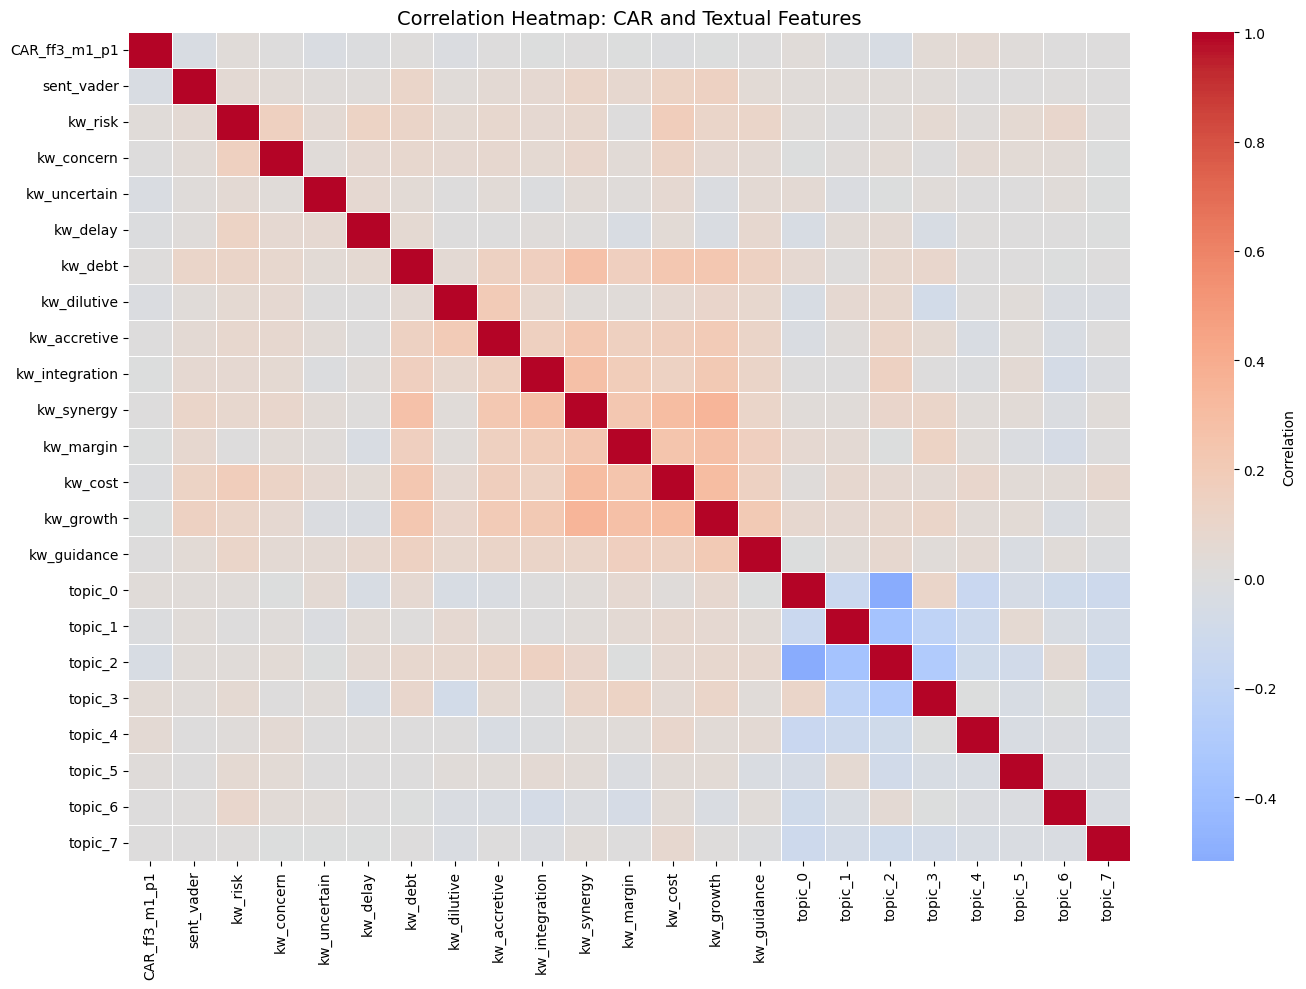

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# variables we want to visually compare with CAR
corr_vars = [
    "CAR_ff3_m1_p1",
    "sent_vader",
    "kw_risk", "kw_concern", "kw_uncertain", "kw_delay",
    "kw_debt", "kw_dilutive", "kw_accretive", "kw_integration",
    "kw_synergy", "kw_margin", "kw_cost", "kw_growth", "kw_guidance"
]

# add topics
topic_vars = [c for c in df.columns if c.startswith("topic_")]
corr_vars += topic_vars

# compute correlation matrix
corr_df = df[corr_vars].corr()

# plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_df,
    cmap="coolwarm",
    center=0,
    linewidths=0.5,
    cbar_kws={"label": "Correlation"}
)

plt.title("Correlation Heatmap: CAR and Textual Features", fontsize=14)
plt.tight_layout()
plt.show()

### Interpreting the correlation heatmap

The heatmap shows the correlation between short-window abnormal returns (CAR −1,+1) and the different textual features, such as sentiment, keyword indicators, and topic shares. Overall, the correlations are very small and close to zero.

This means that changes in tone, the use of risk or uncertainty-related words, or differences in thematic content are not strongly linked to immediate stock price reactions around announcement dates. In other words, firms that use more positive or more cautious language do not systematically experience higher or lower abnormal returns in the short run.

This visual result is consistent with the regression analysis above and supports the idea that short-term market reactions are mainly driven by the economic substance of the event itself, rather than by how the information is worded in related news or disclosures.

# Further analysis

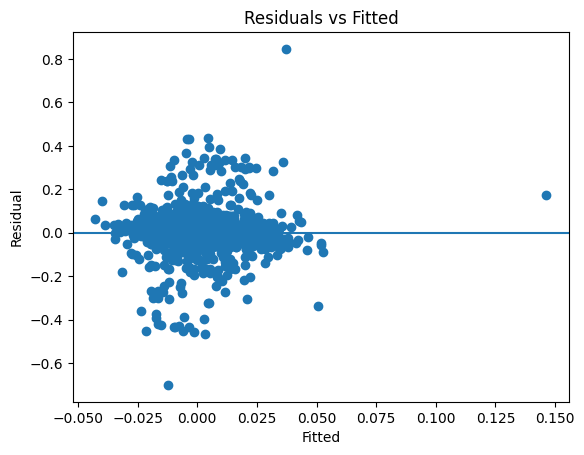

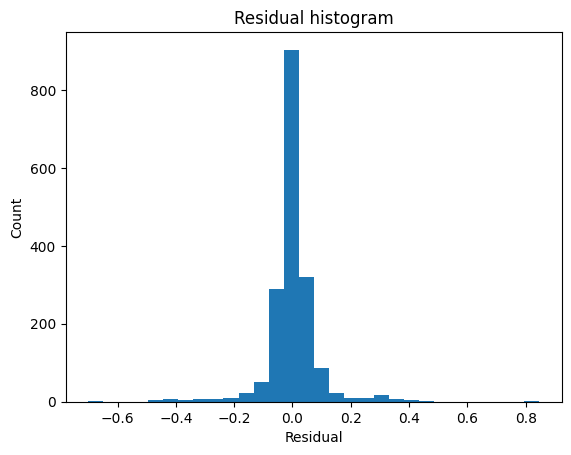

{'LM stat': np.float64(56.94235430894191),
 'LM p-value': np.float64(0.10916569358711974),
 'F stat': np.float64(1.2733844017665428),
 'F p-value': np.float64(0.10699069697368616)}

In [15]:
resid  = model.resid
fitted = model.fittedvalues

plt.figure()
plt.scatter(fitted, resid)
plt.axhline(0)
plt.title("Residuals vs Fitted")
plt.xlabel("Fitted")
plt.ylabel("Residual")
plt.show()

plt.figure()
plt.hist(resid, bins=30)
plt.title("Residual histogram")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()

bp = het_breuschpagan(resid, model.model.exog)
bp_labels = ["LM stat", "LM p-value", "F stat", "F p-value"]
dict(zip(bp_labels, bp))

In [16]:
jb_stat, jb_p, skew, kurt = jarque_bera(resid)
ad_stat, ad_p = normal_ad(resid)

print({"JB_stat": jb_stat, "JB_p": jb_p, "AD_stat": ad_stat, "AD_p": ad_p, "skew": skew, "kurtosis": kurt})

reset = linear_reset(model, power=2, use_f=True)
print({"RESET_F": float(reset.fvalue), "RESET_p": float(reset.pvalue)})

{'JB_stat': np.float64(16113.023703874032), 'JB_p': np.float64(0.0), 'AD_stat': np.float64(inf), 'AD_p': 0.0, 'skew': np.float64(0.02571062487156738), 'kurtosis': np.float64(17.706445975235198)}
{'RESET_F': 4.895475496499097, 'RESET_p': 0.02705649766199999}


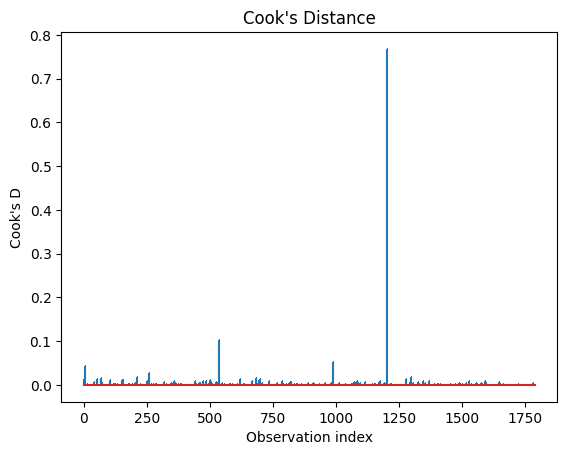

,file_name,file_date,RIC,CAR_ff3_m1_p1
1232,2014-Dec-16-TLM.TO^E15-140114470805-Brief.txt,2014-12-16,TLM.TO^E15,0.319487
552,2008-Jan-02-KTOS.OQ-139380119552-Brief.txt,2008-01-02,KTOS.OQ,-0.285638
1014,2011-Oct-24-ARWR.OQ-138605471022-Brief.txt,2011-10-24,ARWR.OQ,0.883096
5,2003-Dec-23-KTOS.OQ-138170059987-Brief.txt,2003-12-23,KTOS.OQ,-0.285638
270,2006-Dec-20-RBAK.OQ^B07-140906486755-Brief.txt,2006-12-20,RBAK.OQ^B07,-0.713001
1329,2015-Sep-04-BB.TO-137076106607-Brief.txt,2015-09-04,BB.TO,-0.473837
219,2005-Oct-31-ABX.TO-137549970932-Brief.txt,2005-10-31,ABX.TO,-0.464389
71,2004-May-19-MG.TO-141163042267-Brief.txt,2004-05-19,MG.TO,0.401511
703,2009-Oct-05-TRIDQ.PK^L12-138733860092-Brief.txt,2009-10-05,TRIDQ.PK^L12,0.427530
55,2004-Jun-14-NVLNF.PK^A20-140203857819-Brief.txt,2004-06-14,NVLNF.PK^A20,-0.459838


In [17]:
influence = model.get_influence()
cooks_d = influence.cooks_distance[0]

plt.figure()
plt.stem(cooks_d, markerfmt=",")
plt.title("Cook's Distance")
plt.xlabel("Observation index")
plt.ylabel("Cook's D")
plt.show()

top_idx = np.argsort(cooks_d)[-10:][::-1]
df.loc[mask].iloc[top_idx][["file_name","file_date","RIC","CAR_ff3_m1_p1"]]

In [18]:
X_vif = X2.drop(columns=["const"])

vif_df = pd.DataFrame({
    "variable": X_vif.columns,
    "VIF": [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
}).sort_values("VIF", ascending=False)

vif_df.head(30)

,variable,VIF
14,log_words,2129.554569
15,log_nums,1020.464872
0,sent_vader,886.969552
18,topic_0,33.550244
33,yr_2011,26.119814
28,yr_2006,22.401795
20,topic_2,20.690265
29,yr_2007,20.401127
32,yr_2010,20.171649
27,yr_2005,19.686225
